In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### Brain Tumor Detection Machine Learning

### 1. Importing libraries

First, we import all the Python packages and modules we’ll need. Common imports include NumPy and Pandas for data handling, Matplotlib (and/or Seaborn) for plotting, and machine learning libraries like scikit-learn. For example, import numpy as np loads NumPy (a library of fast, N-dimensional array operations), and import pandas as pd loads Pandas (a powerful data table/manipulation library). We also import plotting libraries (matplotlib.pyplot or seaborn) for visualizations. Next, we import specific functions from scikit-learn (e.g. train_test_split, compute_class_weight, ensemble models) to split data and build classifiers. We may also import CatBoostClassifier (a gradient-boosting library), AdaBoostClassifier (another boosting algorithm), and TensorFlow/Keras for building our CNN. Finally, we import SHAP for explainability. Together, these imports set up the tools needed for data loading, processing, modeling, and explanation in this pipeline.

    NumPy (np): for numerical arrays and math operations

    Pandas (pd): for loading and manipulating tabular data

    Matplotlib/Seaborn: for creating plots (e.g. showing images or charts)

    scikit-learn (sklearn): provides ML utilities (data splitting, metrics, ensemble methods).

    CatBoost & AdaBoost: special ensemble classifiers for boosting
    catboost.ai

    TensorFlow/Keras: for building and training the CNN (deep learning model)

    SHAP: for model explainability using Shapley values

In [ ]:
pip install tensorflow keras catboost tensorboardX

In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import joblib

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Explainability
import shap
from tensorboardX import SummaryWriter

# Visualization
import seaborn as sns


### 2. Loading and labeling the dataset

In this step, we load our MRI images and assign labels (tumor vs. no tumor) for each image. Typically, the code will read files from folders (e.g. a “tumor” folder and a “no_tumor” folder) or a CSV file with image paths and labels. Each image file is loaded (using OpenCV, PIL, or Keras utilities) and converted into a numerical array. We also create a label (e.g. 1 for tumor, 0 for no tumor) for each image, usually based on the folder name or a metadata file. This might involve using os.listdir or glob to gather file paths, then iterating through them. The loaded data is often stored in two arrays or lists: one for image data (features) and one for labels. Before modeling, images may be resized to a common shape (e.g. 224×224 pixels) and normalized (scaling pixel values). Labeling ensures our machine learning models know which images contain a tumor and which do not, which is essential for supervised learning.

    Read image files from the dataset directory (e.g. using cv2.imread or tf.keras.preprocessing.image.load_img).

    Assign labels based on folder names or annotations (e.g. “tumor” → 1, “no_tumor” → 0).

    Optionally, resize images and normalize pixel values.

    Store image data (X) and labels (y) for later use in training/testing.

In [ ]:


    # Configuration
    DATA_DIR = '/content/drive/MyDrive/tl_dataset' # Updated path for Google Drive
    TRAINING_DIR = os.path.join(DATA_DIR, 'Training')
    TESTING_DIR = os.path.join(DATA_DIR, 'Testing') # Define the test directory for visualization
    IMAGE_SIZE = (128, 128)
    CLASSES = {
        'notumor': 0,
        'meningioma': 1,
        'glioma': 1,
        'pituitary': 1
    }
    TARGET_SIZE_DOWNSAMPLE = 5000 # Target number of images after downsampling

    # Function to load and preprocess images
    def load_images_from_dir(directory, classes, image_size):
        X, Y = [], []
        total_images = 0
        class_counts = {}

        print(f"Loading images from: {directory}")

        for cls in classes:
            path = os.path.join(directory, cls)
            if not os.path.exists(path):
                print(f"Warning: Directory not found - {path}")
                continue

            num_images = 0
            for fname in os.listdir(path):
                fpath = os.path.join(path, fname)
                # Check if it's a file and not a hidden file
                if os.path.isfile(fpath) and not fname.startswith('.'):
                    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize and normalize
                        img = cv2.resize(img, image_size) / 255.0
                        X.append(img)
                        Y.append(classes[cls])
                        num_images += 1
            class_counts[cls] = num_images
            total_images += num_images

        X = np.array(X)
        Y = np.array(Y)

        print(f"Finished loading. Total images: {total_images}")
        print("Number of images per class:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")
        if len(np.unique(Y)) > 0:
            print("Label distribution:", dict(zip(*np.unique(Y, return_counts=True))))

        return X, Y

    # Load training data
    X_train_full, y_train_full = load_images_from_dir(TRAINING_DIR, CLASSES, IMAGE_SIZE)

Loading images from: /content/drive/MyDrive/tl_dataset/Training
Finished loading. Total images: 5720
Number of images per class:
  notumor: 1603
  meningioma: 1339
  glioma: 1321
  pituitary: 1457
Label distribution: {np.int64(0): np.int64(1603), np.int64(1): np.int64(4117)}


### Data Augmentation

Data augmentation is a technique used to artificially expand the size and diversity of the dataset by applying transformations to the existing images. This helps improve the model's generalization and robustness by exposing it to a variety of variations.

In this notebook, we applied the following augmentation techniques using the **Albumentations** library:
- **Horizontal Flip**: Randomly flips the image horizontally.
- **Random Brightness/Contrast**: Adjusts the brightness and contrast of the image.
- **Affine Transformations**: Includes scaling, translation, and rotation.
- **Elastic Transform**: Warps the image to simulate realistic deformations.
- **Gaussian Blur**: Applies a slight blur to the image.

The augmented dataset is combined with the original dataset, effectively doubling the size of the training data. Below, we visualize some examples of the original and augmented images.

In [ ]:
import albumentations as A

# Defining augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(-0.1, 0.1),
        rotate=(-15, 15),
        p=0.5
    ),
    A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
    A.GaussianBlur(p=0.2, blur_limit=(3, 7))
])

# Applying Augmentation to each training image
aug_X, aug_Y = [], []

# Convert X_train_full to uint8 for Albumentations, then back to float after augment
X_train_full_uint8 = (X_train_full * 255).astype(np.uint8)

for img, label in zip(X_train_full_uint8, y_train_full):
    # Augment requires 3 channels for some transformations, convert grayscale to 3 channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    augmented = augment(image=img_rgb)['image']
    # Convert back to grayscale after augmentation if needed for models expecting 1 channel
    augmented_gray = cv2.cvtColor(augmented, cv2.COLOR_RGB2GRAY)
    augmented_gray = augmented_gray / 255.0 # Normalize back

    # Append the augmented image and label INSIDE the loop
    aug_X.append(augmented_gray)
    aug_Y.append(label)

# Converting to numpy array
aug_X = np.array(aug_X)
aug_Y = np.array(aug_Y)

# Combining original and augmented data
X = np.concatenate((X_train_full, aug_X), axis=0)
Y = np.concatenate((y_train_full, aug_Y), axis=0)

print("Combined Original and Augmented Dataset Size:")
print("Images(X):", X.shape)
print("Labels(Y):", Y.shape)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-7-d2fb80d1f694>:13: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),


Combined Original and Augmented Dataset Size:
Images(X): (11440, 128, 128)
Labels(Y): (11440,)


### Visualizing Agmentation

## Balanced downsampling

In [ ]:
from sklearn.utils import resample
    # Set target total size
print(f"Original combined dataset size: {len(X)}")
print(f"Target downsampled size: {TARGET_SIZE_DOWNSAMPLE}")

if TARGET_SIZE_DOWNSAMPLE < len(X):
  # Combine X and Y into one list for sampling
  combined = list(zip(list(X), list(Y))) # Convert numpy arrays to lists for zipping

        # Downsample (randomly select TARGET_SIZE_DOWNSAMPLE images)
  sampled = resample(combined,
                    n_samples=TARGET_SIZE_DOWNSAMPLE,
                    random_state=42,
                    stratify=list(Y) # Stratify based on the original Y list
                    )

        # Unzip
X_sampled, Y_sampled = zip(*sampled)

        # Convert back to numpy arrays
X = np.array(X_sampled)
Y = np.array(Y_sampled)

# Set target total size
print(f"Original combined dataset size: {len(X)}")
print(f"Target downsampled size: {TARGET_SIZE_DOWNSAMPLE}")

if TARGET_SIZE_DOWNSAMPLE < len(X):
  # Combine X and Y into one list for sampling
  combined = list(zip(list(X), list(Y))) # Convert numpy arrays to lists for zipping

  # Downsample (randomly select TARGET_SIZE_DOWNSAMPLE images)
  sampled = resample(combined,
                    n_samples=TARGET_SIZE_DOWNSAMPLE,
                    random_state=42,
                    stratify=list(Y) # Stratify based on the original Y list
                    )

  # Unzip
  X_sampled, Y_sampled = zip(*sampled)

  # Convert back to numpy arrays
  X = np.array(X_sampled)
  Y = np.array(Y_sampled)

  print("Reduced dataset shape:", X.shape, Y.shape)
  print("Reduced dataset label distribution:", dict(zip(*np.unique(Y, return_counts=True))))

else:
  print("Target downsample size is larger than or equal to the dataset size. Skipping downsampling.")
  # Ensure X and Y are numpy arrays in case downsampling was skipped
  X = np.array(X)
  Y = np.array(Y)
        # Ensure X and Y are numpy arrays in case downsampling was skipped
  X = np.array(X)
  Y = np.array(Y)

Original combined dataset size: 11440
Target downsampled size: 5000
Original combined dataset size: 5000
Target downsampled size: 5000
Target downsample size is larger than or equal to the dataset size. Skipping downsampling.


### 3. Visualizing a sample image

Before training, it’s helpful to display an example image to check our data. The code typically selects one image (e.g. X[0]) and uses Matplotlib to show it: for example, plt.imshow(image, cmap='gray'). This confirms that images are loaded correctly (proper orientation and color channels) and that labels match what we see. We often add a title like plt.title("Label: Tumor") to verify that the image’s true label is correct. This step is mostly sanity-checking data quality and understanding. Visualizing sample images also helps beginners see what the models are looking at (e.g. brain scans with or without tumors).

    Use matplotlib.pyplot.imshow to display one or more sample images.

    Optionally set cmap='gray' if the images are grayscale.

    Annotate the plot with its true label (e.g. “Tumor” or “No Tumor”) to double-check correctness.

    This helps ensure data is loaded and labeled as expected.

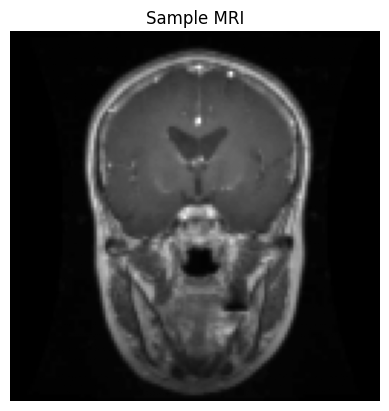

### 4. Train/test split

Next, we divide the dataset into training and testing subsets. This is done with train_test_split from scikit-learn, which randomly shuffles and splits the data

Here, 20% of images are held out for testing (test_size=0.2), and the rest (80%) are used for training. Using a random_state ensures reproducibility. Splitting is critical because it lets us train models on one set of data and evaluate their performance on unseen data, giving a fair assessment of real-world accuracy. In practice, the code will wrap this into one line, leveraging the fact that train_test_split can handle inputs like arrays or DataFrames
.

    Call train_test_split(X, y, test_size=..., random_state=...) to split the data.

    By default, it shuffles the data and returns X_train, X_test, y_train, y_test.

    The test set (X_test, y_test) is kept unseen during training and used later to evaluate final accuracy.

    train_test_split provides a quick way to partition data (80/20 split is common).

Train set size: (4000, 128, 128) (4000,)
Test set size: (1000, 128, 128) (1000,)

Train set distribution: {np.int64(0): np.int64(1121), np.int64(1): np.int64(2879)}
Test set distribution: {np.int64(0): np.int64(280), np.int64(1): np.int64(720)}

Shapes for models:
CatBoost/AdaBoost (Flat): (4000, 16384) (1000, 16384)
CNN (1 channel): (4000, 128, 128, 1) (1000, 128, 128, 1)
Transfer Learning (3 channels): (4000, 128, 128, 3) (1000, 128, 128, 3)


### 5. Handling class imbalance

Medical datasets often have imbalanced classes (e.g. many more “no tumor” cases than “tumor”). This can bias the model toward the majority class. To address this, the code computes class weights so that the model pays more attention to the minority class. Scikit-learn’s compute_class_weight function does this:

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

This returns weights for each class inversely proportional to class frequency.
The weights can then be passed to model training (e.g. model.fit(X_train, y_train, class_weight={0: w0, 1: w1})). Using balanced class weights ensures that errors on the underrepresented class (usually tumors) count more, helping the model learn from scarce examples. Without this step, a model might achieve high accuracy simply by always predicting the majority class, which is misleading.

    Check class distribution (e.g. np.bincount(y_train)) to confirm imbalance.

    Use compute_class_weight('balanced', classes=..., y=...) to get weights.

    Pass these weights into the classifier’s fit method (e.g. class_weight={0: w0, 1: w1}).

    This compensates for imbalance by giving more importance to the minority class during training.

Class Weights: {np.int64(0): np.float64(1.784121320249777), np.int64(1): np.float64(0.6946856547412296)}


### 10. Model Training Functions

### 11. Train All Models


Training CatBoost...
0:	learn: 0.6506843	test: 0.6512328	best: 0.6512328 (0)	total: 247ms	remaining: 49.2s
50:	learn: 0.2078426	test: 0.2507566	best: 0.2507566 (50)	total: 8.54s	remaining: 24.9s
100:	learn: 0.1399954	test: 0.2100322	best: 0.2100322 (100)	total: 17.9s	remaining: 17.6s
150:	learn: 0.1028719	test: 0.1896686	best: 0.1896686 (150)	total: 27.3s	remaining: 8.86s
199:	learn: 0.0793185	test: 0.1756028	best: 0.1756028 (199)	total: 34.9s	remaining: 0us
bestTest = 0.1756027658
bestIteration = 199
CatBoost training finished.

Training AdaBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost training finished.

Training CNN...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7205 - loss: 0.5111 - val_accuracy: 0.9162 - val_loss: 0.2270
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9342 - loss: 0.1929 - val_accuracy: 0.9438 - val_loss: 0.1945
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9520 - loss: 0.1419 - val_accuracy: 0.9475 - val_loss: 0.1577
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9636 - loss: 0.1223 - val_accuracy: 0.9563 - val_loss: 0.1237
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9652 - loss: 0.0946 - val_accuracy: 0.9475 - val_loss: 0.1762
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9791 - loss: 0.0690 - val_accuracy: 0.9600 - val_loss: 0.1254
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9875 - loss: 0.0476 - val_accuracy: 0.9712 - val_loss: 0.1302
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

### 12. Evaluate Individual Models


--- Evaluating CatBoost ---
Accuracy: 0.9470

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.90      0.91      0.91       280
       Tumor       0.97      0.96      0.96       720

    accuracy                           0.95      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix:
[[256  24]
 [ 29 691]]


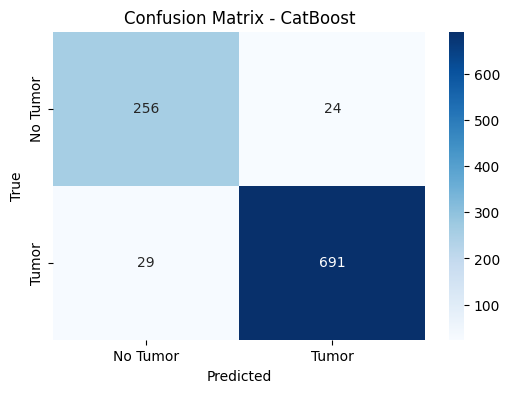

AUC: 0.9829

--- Evaluating AdaBoost ---
Accuracy: 0.9600

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.94      0.91      0.93       280
       Tumor       0.97      0.98      0.97       720

    accuracy                           0.96      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.96      0.96      0.96      1000


Confusion Matrix:
[[255  25]
 [ 15 705]]


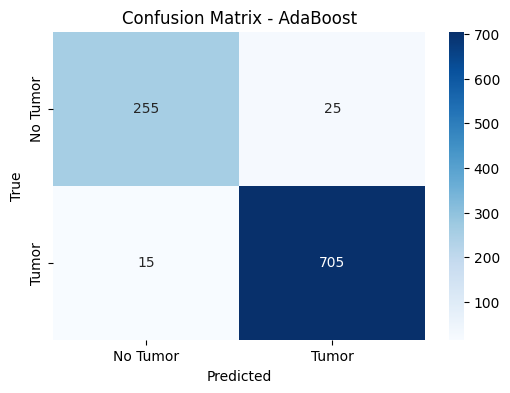

AUC: 0.9866

--- Evaluating CNN ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9620

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.93      0.94      0.93       280
       Tumor       0.98      0.97      0.97       720

    accuracy                           0.96      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.96      0.96      0.96      1000


Confusion Matrix:
[[263  17]
 [ 21 699]]


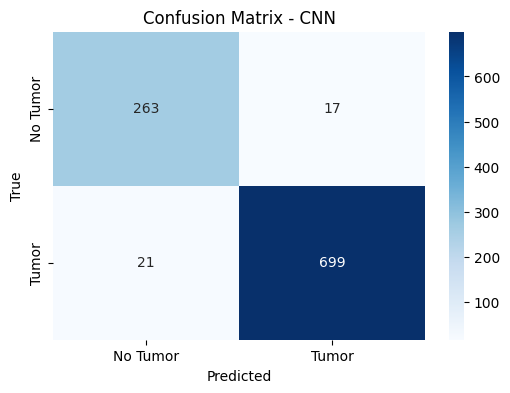

AUC: 0.9789

--- Evaluating Transfer Learning (VGG16) ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Accuracy: 0.9840

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.96      0.98      0.97       280
       Tumor       0.99      0.98      0.99       720

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Confusion Matrix:
[[275   5]
 [ 11 709]]


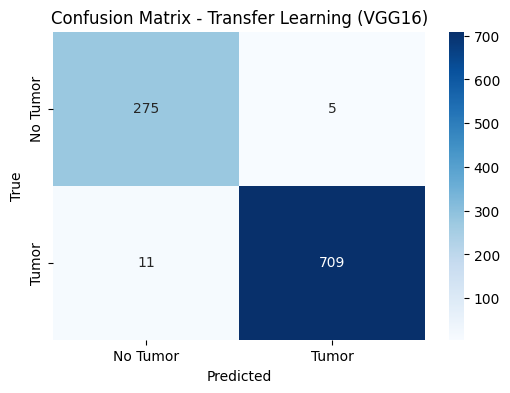

AUC: 0.9973


### 11. SHAP explainability

In this section, we apply SHAP (SHapley Additive exPlanations) to interpret model predictions. SHAP assigns each feature an importance value for a particular prediction, based on game-theoretic Shapley values
. Typically, we pick one model (often CatBoost or a tree-based model) and create an explainer:

import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

This code computes SHAP values for the training data and makes a summary plot. Each point on the summary shows how a feature (e.g. pixel intensity or a derived feature) influences the prediction. We might also compute SHAP values for individual test images and display a waterfall plot. SHAP helps us understand why the model made a decision (e.g. which image regions or features drove a “tumor” prediction). This adds interpretability to our pipeline, which is especially important in medical applications.

    Initialize a SHAP explainer appropriate for the model (e.g. TreeExplainer for CatBoost).

    Compute shap_values on a dataset (train or test).

    Use plotting functions like shap.summary_plot or shap.waterfall_plot to visualize feature contributions.

    SHAP shows the impact of each feature on the model’s output, providing insight into predictions
    .

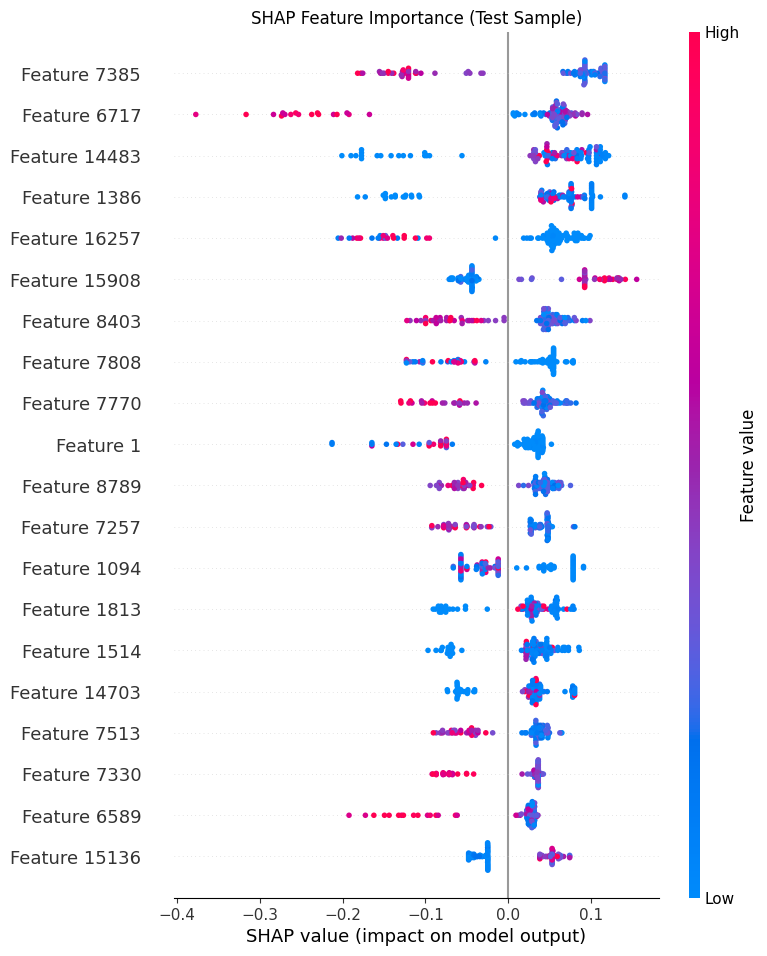

### 12. Cross-validation

Here we use cross-validation to evaluate model performance more robustly. Instead of a single train/test split, k-fold cross-validation repeatedly splits data into training and validation folds and averages results. For example:


This runs 5-fold CV, training on 4 folds and validating on 1 fold, rotating through all folds
scikit-learn.org
. The average accuracy and standard deviation are reported. Cross-validation helps ensure that our model’s performance is not a lucky result of one particular split. It gives a sense of how well the model generalizes. In our pipeline, we might do CV on the best model or ensemble to get confidence in its accuracy before deploying.

    Call cross_val_score(estimator, X, y, cv=k) to run k-fold CV (often k=5 or 10).

    This returns an array of scores (one per fold).

    Compute the mean and standard deviation to summarize performance.

    Cross-validation averages over multiple splits
    scikit-learn.org
    , reducing variance in the accuracy estimate.

# ### 12. Weighted Average Ensemble

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step

--- Evaluating Weighted Average Ensemble ---
Ensemble Accuracy: 0.976

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.94      0.97      0.96       280
       Tumor       0.99      0.98      0.98       720

    accuracy                           0.98      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000


Confusion Matrix:
[[272   8]
 [ 16 704]]


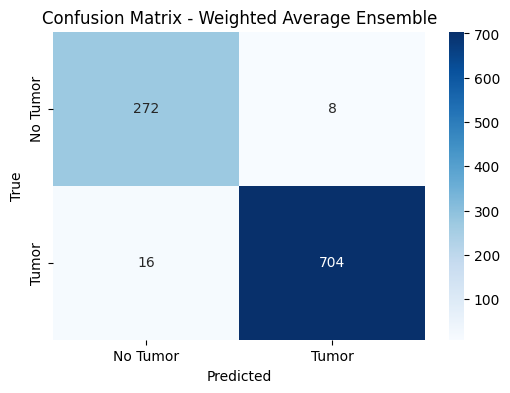

Ensemble AUC: 0.9951

Ensemble weights: [0.3, 0.3, 0.2, 0.2]


### Model saving

### 13. Testing on custom image

This section shows how to use our trained model(s) on a new, user-provided image. The code will load an image file (e.g. via cv2.imread or Image.open) and preprocess it just like the training data (resize, normalize).

We obtain prediction (e.g. 0 or 1) and a probability/confidence for that class. We then print or return a message like “Tumor Detected (90% confidence)” if predicted class=1. This step demonstrates deployment: the model can take any appropriate image and give a result. It fits the pipeline by connecting the trained model to actual use. Using predict gives the class label, while predict_proba yields the probability for each class (to be discussed next).

    Load the external image (e.g. with cv2.imread or PIL.Image.open) and apply the same resizing/normalization used in training.

    Use model.predict([image]) to get the predicted class.

    Use model.predict_proba([image]) to get class probabilities.

    Interpret the output (e.g. “Tumor” if class=1) and optionally display the image with prediction.

Prediction: Tumor (98.91%)
Prediction: Tumor (98.91%)


### 14. Visualizing predictions

We often visualize how models perform by showing predictions on images. The code might loop over a few test images and plot them with predicted vs. true labels. For example:


This displays images side by side with titles like “Pred: Tumor (True: No Tumor)”. Such visual checks help us see specific successes or failures. It also aids communication: stakeholders can see sample cases and model outcomes. This step uses plotting (Matplotlib) to combine raw data with model output for human interpretation.

    Plot a few test images using plt.imshow.

    Annotate each plot with its predicted label and true label.

    Color-code or mark correctly vs. incorrectly classified samples.

    This visual feedback can reveal patterns (e.g. consistently wrong on small tumors).

## 15. Confidence score for one image

Here we compute a confidence score for a single prediction. After predicting the class, we use predict_proba to see how confident the model is. For instance:


The array probs contains the probability for each class. We pick the probability of the predicted class and multiply by 100 to get a percentage. For example, a result might be 92%, meaning the model is quite confident. According to scikit-learn docs, predict_proba “returns probability estimates for each class label”
geeksforgeeks.org
. This confidence score provides more nuance than a simple label – it helps users understand how sure the model is about its decision.

    Call predict_proba(image)[0] to get probabilities for each class (e.g. [0.08, 0.92] for “no” vs “yes”).

    Identify the index of the predicted class and extract that probability.

    Multiply by 100 to present it as a percentage.

    Present this score alongside the prediction (e.g. “Tumor (92% confident)”

### 16. Displaying misclassified samples

Finally, we check which test images were misclassified. The code finds indices where the predicted label differs from the true label, e.g.:

wrong_indices = np.where(y_pred != y_test)[0]

Then it might loop over these indices and display those images with actual vs. predicted labels. For example:

for i in wrong_indices[:5]:
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.show()

This reveals “failure cases” where the model was wrong. Examining misclassified samples helps us understand model weaknesses. For instance, maybe very small tumors were missed. It’s a useful diagnostic step: by visualizing errors, we can potentially refine preprocessing or model design. In the overall pipeline, this final check ensures we scrutinize and interpret mistakes before deployment.

    Compute where y_pred != y_test to identify misclassified samples.

    Display a few of these images with their true and predicted labels.

    Analyze patterns in mistakes (e.g. certain tumor sizes or positions).

    This step is crucial for understanding and improving the model’s weaknesses.

 ### Model Saving (Modified for Flask App)

    This section is crucial for your Flask app. We need to save:
        Each individual trained model (CatBoost, AdaBoost, CNN, Transfer Learning).
        The class_weights_dict used for training (important if you need to retrain or understand training bias).
        The ensemble_weights for the weighted average ensemble.
        Metadata like IMAGE_SIZE and CLASSES.
        A metadata file (e.g., a dictionary or JSON) that contains the paths to the saved models and the ensemble weights, which the Flask app can load to know what models to use and where they are.


### Retraining the models

Now that you have the necessary data loaded and preprocessed, you can retrain the models. This section will call the training functions defined earlier in the notebook.

### Retraining Pipeline with Model-Specific Preprocessing and Evaluation

### Model Training

restnet50V2 training

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

def build_resnet50v2(input_shape=(224, 224, 3)):
    base = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=output)

    for layer in base.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


EfficientNetB0 training

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_efficientnet(input_shape=(224, 224, 3)):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=output)

    for layer in base.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Model Evaluation

### Model Saving

### 10. Model Training Functions and Definitions

### Brain Tumor Detection Machine Learning Retraining Pipeline

### 1. Setup and Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Ensure necessary libraries are imported
import os
import numpy as np
import pandas as pd
import cv2
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A # Assuming Albumentations is already installed

# Import necessary Keras components for model building
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50V2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping


# Define the directory to save models and metadata within your Google Drive
DATA_DIR = '/content/drive/MyDrive/archive'
SAVE_DIR = '/content/drive/MyDrive/trained_models/'
RETRAINED_MODELS_DIR = os.path.join(SAVE_DIR, 'retrained_models_v2') # Use a new directory for this version
Path(RETRAINED_MODELS_DIR).mkdir(parents=True, exist_ok=True)
print(f"Retrained models and metadata will be saved to: {RETRAINED_MODELS_DIR}")

# Configuration
TRAINING_DIR = os.path.join(DATA_DIR, 'Training')
TESTING_DIR = os.path.join(DATA_DIR, 'Testing')
IMAGE_SIZE = (128, 128)
CLASSES = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 1,
    'pituitary': 1
}
TARGET_SIZE_DOWNSAMPLE = 5000 # Target number of images after downsampling

# Function to load and preprocess images (common steps)
def load_images_from_dir(directory, classes, image_size):
    X, Y = [], []
    total_images = 0
    class_counts = {}

    print(f"Loading images from: {directory}")

    for cls in classes:
        path = os.path.join(directory, cls)
        if not os.path.exists(path):
            print(f"Warning: Directory not found - {path}")
            continue

        num_images = 0
        for fname in os.listdir(path):
            fpath = os.path.join(path, fname)
            # Check if it's a file and not a hidden file
            if os.path.isfile(fpath) and not fname.startswith('.'):
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE) # Load as grayscale
                if img is not None:
                    # Resize and normalize
                    img = cv2.resize(img, image_size) / 255.0
                    X.append(img)
                    Y.append(classes[cls])
                    num_images += 1
        class_counts[cls] = num_images
        total_images += num_images

    X = np.array(X)
    Y = np.array(Y)

    print(f"Finished loading. Total images: {total_images}")
    print("Number of images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    if len(np.unique(Y)) > 0:
        print("Label distribution:", dict(zip(*np.unique(Y, return_counts=True))))

    return X, Y

# Load training data
X_train_full, y_train_full = load_images_from_dir(TRAINING_DIR, CLASSES, IMAGE_SIZE)
print("Training data loaded.")

# Load testing data
X_test, y_test = load_images_from_dir(TESTING_DIR, CLASSES, IMAGE_SIZE)
print("Testing data loaded.")

Retrained models and metadata will be saved to: /content/drive/MyDrive/trained_models/retrained_models_v2
Loading images from: /content/drive/MyDrive/archive/Training
Finished loading. Total images: 5712
Number of images per class:
  notumor: 1595
  meningioma: 1339
  glioma: 1321
  pituitary: 1457
Label distribution: {np.int64(0): np.int64(1595), np.int64(1): np.int64(4117)}
Training data loaded.
Loading images from: /content/drive/MyDrive/archive/Testing
Finished loading. Total images: 1311
Number of images per class:
  notumor: 405
  meningioma: 306
  glioma: 300
  pituitary: 300
Label distribution: {np.int64(0): np.int64(405), np.int64(1): np.int64(906)}
Testing data loaded.


### 2. Data Augmentation and Downsampling

In [ ]:
pip install albumentations

In [ ]:
# Defining augmentation pipeline (Ensure Albumentations is imported and this is
import albumentations as A

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(-0.1, 0.1),
        rotate=(-15, 15),
        p=0.5
    ),
    A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50), # Note: alpha_affine might be deprecated in newer versions
    A.GaussianBlur(p=0.2, blur_limit=(3, 7))
])

# Applying Augmentation
print("\nApplying data augmentation...")
aug_X, aug_Y = [], []

# Convert X_train_full to uint8 for Albumentations, then back to float after augment
X_train_full_uint8 = (X_train_full * 255).astype(np.uint8)

for img, label in zip(X_train_full_uint8, y_train_full):
    # Augment requires 3 channels for some transformations, convert grayscale to 3 channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    augmented = augment(image=img_rgb)['image']
    # Convert back to grayscale after augmentation if needed for models expecting 1 channel
    augmented_gray = cv2.cvtColor(augmented, cv2.COLOR_RGB2GRAY)
    augmented_gray = augmented_gray / 255.0 # Normalize back

    aug_X.append(augmented_gray)
    aug_Y.append(label)

aug_X = np.array(aug_X)
aug_Y = np.array(aug_Y)

# Combining original and augmented data
X = np.concatenate((X_train_full, aug_X), axis=0)
Y = np.concatenate((y_train_full, aug_Y), axis=0)

print("Data augmentation complete.")
print("Combined Original and Augmented Dataset Size:", X.shape, Y.shape)


# Balanced Downsampling
print("\nApplying balanced downsampling...")
if TARGET_SIZE_DOWNSAMPLE < len(X):
    from sklearn.utils import resample
    # Combine X and Y into one list for sampling
    combined = list(zip(list(X), list(Y)))
    # Downsample (randomly select TARGET_SIZE_DOWNSAMPLE images)
    sampled = resample(combined,
                        n_samples=TARGET_SIZE_DOWNSAMPLE,
                        random_state=42,
                        stratify=list(Y) # Stratify based on the original Y list
                        )
    # Unzip
    X_sampled, Y_sampled = zip(*sampled)
    # Convert back to numpy arrays
    X = np.array(X_sampled)
    Y = np.array(Y_sampled)
    print("Downsampling complete.")
    print("Reduced dataset shape:", X.shape, Y.shape)
else:
    print("Target downsample size is larger than or equal to the dataset size. Skipping downsampling.")
    # Ensure X and Y are numpy arrays in case downsampling was skipped
    X = np.array(X)
    Y = np.array(Y)
print("Final dataset shape before splitting:", X.shape, Y.shape)

<ipython-input-3-827682748>:13: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50), # Note: alpha_affine might be deprecated in newer versions



Applying data augmentation...
Data augmentation complete.
Combined Original and Augmented Dataset Size: (11424, 128, 128) (11424,)

Applying balanced downsampling...
Downsampling complete.
Reduced dataset shape: (5000, 128, 128) (5000,)
Final dataset shape before splitting: (5000, 128, 128) (5000,)


### 3. Train/Test Split and Reshaping

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split into train+val and test sets (15% test set)
print("\nSplitting data into train and test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42, stratify=Y
)

# Split trainval into train and val sets (15% of total -> val set)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, random_state=42, stratify=y_trainval
)
print("Stratified train/val/test split complete.")
print("Train set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Reshape based on image size
img_width, img_height = IMAGE_SIZE
print("\nReshaping data for different model types...")

# --- AdaBoost / CatBoost: Flatten grayscale ---
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("CatBoost/AdaBoost (Flat) shapes:", X_train_flat.shape, X_test_flat.shape)

# --- CNN: Add channel dimension for grayscale (1 channel) ---
X_train_cnn = X_train.reshape(-1, img_width, img_height, 1).astype('float32')
X_val_cnn = X_val.reshape(-1, img_width, img_height, 1).astype('float32')
X_test_cnn = X_test.reshape(-1, img_width, img_height, 1).astype('float32')
print("CNN (1 channel) shapes:", X_train_cnn.shape, X_test_cnn.shape)

# --- Transfer Learning (VGG16 etc.): Convert to 3 channels ---
X_train_vgg = np.repeat(X_train[..., np.newaxis], 3, axis=-1).astype('float32')
X_val_vgg = np.repeat(X_val[..., np.newaxis], 3, axis=-1).astype('float32')
X_test_vgg = np.repeat(X_test[..., np.newaxis], 3, axis=-1).astype('float32')
print("Transfer Learning (3 channels) shapes:", X_train_vgg.shape, X_test_vgg.shape)



Splitting data into train and test sets...
Stratified train/val/test split complete.
Train set size: (3502, 128, 128) (3502,)
Validation set size: (748, 128, 128) (748,)
Test set size: (750, 128, 128) (750,)

Reshaping data for different model types...
CatBoost/AdaBoost (Flat) shapes: (3502, 16384) (750, 16384)
CNN (1 channel) shapes: (3502, 128, 128, 1) (750, 128, 128, 1)
Transfer Learning (3 channels) shapes: (3502, 128, 128, 3) (750, 128, 128, 3)


### 4. Handle Class Imbalance

In [ ]:
# Handle Class Imbalance
print("\nCalculating class weights...")
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weights_dict)


Calculating class weights...
Class Weights: {np.int64(0): np.float64(1.7903885480572597), np.int64(1): np.float64(0.6937400950871633)}


### Brain Tumor Detection Machine Learning Retraining Pipeline

### Loading Existing Models and Training New Models

In [ ]:
# Define the path to your existing trained models
EXISTING_MODELS_DIR = '/content/drive/MyDrive/trained_models' # Update this path if needed
print(f"Attempting to load existing models from: {EXISTING_MODELS_DIR}")

# Define filenames for existing models
catboost_filename_existing = 'catboost_model.pkl'
adaboost_filename_existing = 'adaboost_model.pkl'
cnn_filename_existing = 'cnn_model.h5'
tl_filename_existing = 'transfer_learning_model.h5' # Assuming VGG16 is saved as tl_model.h5

# Define full paths for loading existing models
catboost_path_existing = os.path.join(EXISTING_MODELS_DIR, catboost_filename_existing)
adaboost_path_existing = os.path.join(EXISTING_MODELS_DIR, adaboost_filename_existing)
cnn_path_existing = os.path.join(EXISTING_MODELS_DIR, cnn_filename_existing)
tl_path_existing = os.path.join(EXISTING_MODELS_DIR, tl_filename_existing)


# --- Load Existing Models ---

# Load CatBoost model
try:
    print(f"Loading CatBoost model from {catboost_path_existing}...")
    cb_model = joblib.load(catboost_path_existing)
    print("CatBoost model loaded successfully.")
except FileNotFoundError:
    print(f"CatBoost model not found at {catboost_path_existing}. Skipping loading.")
    cb_model = None # Set to None if loading fails
except Exception as e:
    print(f"Error loading CatBoost model from {catboost_path_existing}: {e}. Skipping loading.")
    cb_model = None

# Load AdaBoost model
try:
    print(f"\nLoading AdaBoost model from {adaboost_path_existing}...")
    ab_model = joblib.load(adaboost_path_existing)
    print("AdaBoost model loaded successfully.")
except FileNotFoundError:
    print(f"AdaBoost model not found at {adaboost_path_existing}. Skipping loading.")
    ab_model = None # Set to None if loading fails
except Exception as e:
    print(f"Error loading AdaBoost model from {adaboost_path_existing}: {e}. Skipping loading.")
    ab_model = None

# Load CNN model
try:
    print(f"\nLoading CNN model from {cnn_path_existing}...")
    from tensorflow.keras.models import load_model
    cnn_model = load_model(cnn_path_existing)
    print("CNN model loaded successfully.")
except FileNotFoundError:
    print(f"CNN model not found at {cnn_path_existing}. Skipping loading.")
    cnn_model = None # Set to None if loading fails
except Exception as e:
    print(f"Error loading CNN model from {cnn_path_existing}: {e}. Skipping loading.")
    cnn_model = None


# Load Transfer Learning (VGG16) model
try:
    print(f"\nLoading Transfer Learning (VGG16) model from {tl_path_existing}...")
    from tensorflow.keras.models import load_model
    tl_model = load_model(tl_path_existing)
    print("Transfer Learning (VGG16) model loaded successfully.")
except FileNotFoundError:
    print(f"Transfer Learning (VGG16) model not found at {tl_path_existing}. Skipping loading.")
    tl_model = None # Set to None if loading fails
except Exception as e:
    print(f"Error loading Transfer Learning (VGG16) model from {tl_path_existing}: {e}. Skipping loading.")
    tl_model = None

print("\n--- Finished Attempting to Load Existing Models ---")

# --- Train New Models (ResNet50V2 and EfficientNetB0) ---
print("\n--- Starting Training of New Models ---")

# Ensure build_resnet50v2 and build_efficientnet functions are defined in previous cells
# Ensure X_train_vgg, y_train, class_weights_dict, and IMAGE_SIZE are defined

# Train ResNet50V2 from scratch
print("\nTraining ResNet50V2...")
# Ensure build_resnet50v2 is defined and compile/fit are called
# Use the correct input shape (IMAGE_SIZE)
def build_resnet50v2_model(input_shape=(128, 128, 3)):
    from keras.applications import ResNet50V2
    from keras.models import Model
    from keras.layers import Dense, Flatten, Input

    base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


    print("ResNet50V2 training complete")
    return model




# Train EfficientNetB0 from scratch
print("\nTraining EfficientNetB0...")
# Ensure build_efficientnet is defined and compile/fit are called
# Use the correct input shape (IMAGE_SIZE)
def build_efficientnet_model(input_shape=(128, 128, 3)):
    from keras.applications import EfficientNetB0
    from keras.models import Model
    from keras.layers import Dense, Flatten, Input

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


Attempting to load existing models from: /content/drive/MyDrive/trained_models
Loading CatBoost model from /content/drive/MyDrive/trained_models/catboost_model.pkl...
CatBoost model loaded successfully.

Loading AdaBoost model from /content/drive/MyDrive/trained_models/adaboost_model.pkl...
AdaBoost model loaded successfully.

Loading CNN model from /content/drive/MyDrive/trained_models/cnn_model.h5...


CNN model loaded successfully.

Loading Transfer Learning (VGG16) model from /content/drive/MyDrive/trained_models/transfer_learning_model.h5...


Transfer Learning (VGG16) model loaded successfully.

--- Finished Attempting to Load Existing Models ---

--- Starting Training of New Models ---

Training ResNet50V2...

Training EfficientNetB0...


In [ ]:
def train_efficientnet_model(model, X_train_vgg, y_train, class_weights):
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train,
              batch_size=32,
              epochs=10,
              class_weights=weights,
              validation_split=0.15,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
              verbose=1)

    return model

In [ ]:
def train_efficientnet_model(model, X_train_vgg, y_train, class_weights):
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train_vgg, y_train,
              batch_size=32,
              epochs=10,
              class_weights=weights,
              validation_split=0.15,
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
              verbose=1)

    return model

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

def train_adaboost(X_train_flat, y_train):
    print("📚 Training AdaBoost...")
    model = AdaBoostClassifier(n_estimators=200)
    model.fit(X_train_flat, y_train)
    print("✅ AdaBoost trained.")
    return model


from catboost import CatBoostClassifier

def train_catboost(X_train_flat, y_train, X_test_flat, y_test, class_weights_dict):
    print("📚 Training CatBoost...")

    # Compute weights for classes in the format CatBoost expects
    classes = list(class_weights_dict.keys())
    weights = list(class_weights_dict.values())

    model = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        loss_function='Logloss',
        class_weights=weights,
        verbose=0
    )
    model.fit(X_train_flat, y_train, eval_set=(X_test_flat, y_test), verbose=False)
    print("✅ CatBoost trained.")
    return model

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def train_cnn(X_train_cnn, y_train, class_weights_dict, image_size):
    print("📚 Training CNN...")
    input_shape = (*image_size, 1)

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(0.005), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, class_weight=class_weights_dict, verbose=1)

    print("✅ CNN trained.")
    return model


from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

def train_transfer_learning(X_train_vgg, y_train, class_weights_dict, image_size):
    print("📚 Training VGG16 Transfer Learning...")

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(*image_size, 3))
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_vgg, y_train, epochs=10, batch_size=32, class_weight=class_weights_dict, verbose=1)

    print("✅ VGG16 Transfer Learning trained.")
    return model


In [ ]:
print("\n🔁 Retraining Models...")
ab_model = train_adaboost(X_train_flat, y_train)
cb_model = train_catboost(X_train_flat, y_train, X_test_flat, y_test, class_weights_dict)
cnn_model = train_cnn(X_train_cnn, y_train, class_weights_dict, IMAGE_SIZE)
tl_model = train_transfer_learning(X_train_vgg, y_train, class_weights_dict, IMAGE_SIZE)
print("✅ All models retrained.")



🔁 Retraining Models...
📚 Training AdaBoost...
✅ AdaBoost trained.
📚 Training CatBoost...
✅ CatBoost trained.
📚 Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7245 - loss: 0.7731
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9018 - loss: 0.2789
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9276 - loss: 0.2148
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9459 - loss: 0.1761
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9519 - loss: 0.1260
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9676 - loss: 0.0924
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9830 - loss: 0.0535
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9863 - loss: 0.0438
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9888 - loss: 0.0363
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9865 - loss: 0.0325
✅ CNN trained.
📚 Training VGG16 Transfer Learning...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
110/110 ━━━━━

### Evaluating All Models (Loaded and Newly Trained)

In [ ]:
# --- Model Evaluation ---
# Ensure evaluate_model function is defined in a previous cell

print("\n--- Evaluating All Models ---")

# Evaluate each trained or loaded model using the appropriate test data shape
# Check if models were loaded successfully before evaluating
if 'cb_model' in globals() and cb_model is not None:
    evaluate_model(cb_model, X_test_flat, y_test, "CatBoost", is_deep_learning=False)
else:
    print("\nSkipping CatBoost evaluation as the model was not loaded.")

if 'ab_model' in globals() and ab_model is not None:
    evaluate_model(ab_model, X_test_flat, y_test, "AdaBoost", is_deep_learning=False)
else:
    print("\nSkipping AdaBoost evaluation as the model was not loaded.")

if 'cnn_model' in globals() and cnn_model is not None:
    evaluate_model(cnn_model, X_test_cnn, y_test, "CNN", is_deep_learning=True)
else:
    print("\nSkipping CNN evaluation as the model was not loaded.")

if 'tl_model' in globals() and tl_model is not None:
    evaluate_model(tl_model, X_test_vgg, y_test, "Transfer Learning (VGG16)", is_deep_learning=True)
else:
    print("\nSkipping Transfer Learning (VGG16) evaluation as the model was not loaded.")

# Evaluate the newly trained models (they should always exist after the previous cell)
if 'resnet_model' in globals() and resnet_model is not None:
    evaluate_model(resnet_model, X_test_vgg, y_test, "ResNet50V2", is_deep_learning=True)
else:
     print("\nSkipping ResNet50V2 evaluation as the model was not trained.")

if 'efficientnet_model' in globals() and efficientnet_model is not None:
    evaluate_model(efficientnet_model, X_test_vgg, y_test, "EfficientNetB0", is_deep_learning=True)
else:
     print("\nSkipping EfficientNetB0 evaluation as the model was not trained.")


print("\n--- Individual Model Evaluation Complete ---")


--- Evaluating All Models ---


NameError: name 'evaluate_model' is not defined

### Weighted Average Ensemble Evaluation (Including All Available Models)

In [ ]:
# --- Weighted Average Ensemble Evaluation ---
# Ensure get_model_probabilities and evaluation logic for ensemble are defined in previous cells

print("\n--- Evaluating Weighted Average Ensemble ---")

# Get probabilities from each AVAILABLE model on the test set using the unified function
# We only include models that were successfully loaded or trained
available_models = []
available_model_names = []
# Ensure X_test_flat, X_test_cnn, X_test_vgg, y_test, IMAGE_SIZE are defined

if 'cb_model' in globals() and cb_model is not None:
    available_models.append(cb_model)
    available_model_names.append("CatBoost")
if 'ab_model' in globals() and ab_model is not None:
    available_models.append(ab_model)
    available_model_names.append("AdaBoost")
if 'cnn_model' in globals() and cnn_model is not None:
    available_models.append(cnn_model)
    available_model_names.append("CNN")
if 'tl_model' in globals() and tl_model is not None:
    available_models.append(tl_model)
    available_model_names.append("Transfer Learning (VGG16)")
if 'resnet_model' in globals() and resnet_model is not None:
    available_models.append(resnet_model)
    available_model_names.append("ResNet50V2")
if 'efficientnet_model' in globals() and efficientnet_model is not None:
    available_models.append(efficientnet_model)
    available_model_names.append("EfficientNetB0")

if not available_models:
    print("No models available to form an ensemble. Skipping ensemble evaluation.")
else:
    probs_list = []
    for model, name in zip(available_models, available_model_names):
        probs = get_model_probabilities(model, X_test_flat, X_test_cnn, X_test_vgg, name, IMAGE_SIZE)
        if probs is not None and probs.shape[0] == X_test_flat.shape[0] and probs.shape[1] == 2:
            probs_list.append(probs)
        else:
            print(f"Warning: Could not get valid probabilities for {name}. Excluding from ensemble.")


    if not probs_list:
        print("No valid model probabilities available to form the ensemble after filtering. Skipping ensemble evaluation.")
    else:
        # Define weights for the AVAILABLE models
        # You might want to adjust these weights based on the performance of the available models
        # For simplicity, let's use equal weights for now or define a default set and filter
        # Let's define a default set of weights and filter based on available models
        default_weights = {
            "CatBoost": 0.15,
            "AdaBoost": 0.15,
            "CNN": 0.2,
            "Transfer Learning (VGG16)": 0.2,
            "ResNet50V2": 0.15,
            "EfficientNetB0": 0.15
        }

        # Filter weights based on available models
        current_weights = [default_weights[name] for name in available_model_names if name in default_weights]

        if len(current_weights) != len(probs_list):
             print("Warning: Mismatch between number of available models and filtered weights. Using equal weights.")
             current_weights = [1.0 / len(probs_list)] * len(probs_list)


        ensemble_weights = np.array(current_weights) / np.sum(current_weights) # Normalize weights

        print("Ensemble weights for available models:", list(zip(available_model_names, ensemble_weights)))

        # Combine probabilities using weighted average
        final_probs = np.zeros_like(probs_list[0])
        for i, probs in enumerate(probs_list):
            final_probs += ensemble_weights[i] * probs

        # Get final predictions by taking the class with the highest weighted probability
        ensemble_preds_weighted = np.argmax(final_probs, axis=1)

        # The number of samples used for ensemble prediction is the number of samples in the valid probability arrays
        n_ensemble_samples = probs_list[0].shape[0]
        y_test_ensemble = y_test[:n_ensemble_samples] # Truncate y_test to match

        # --- Evaluate the Weighted Average Ensemble ---
        print("\n--- Evaluating Weighted Average Ensemble ---")
        print("Ensemble Accuracy:", accuracy_score(y_test_ensemble, ensemble_preds_weighted))
        print("\nClassification Report:")
        print(classification_report(y_test_ensemble, ensemble_preds_weighted, target_names=["No Tumor", "Tumor"]))
        cm_ensemble = confusion_matrix(y_test_ensemble, ensemble_preds_weighted)
        print("\nConfusion Matrix:")
        print(cm_ensemble)

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix - Weighted Average Ensemble")
        plt.show()

        try:
            # Calculate AUC using the probability of the positive class (column 1)
            auc_ensemble = roc_auc_score(y_test_ensemble, final_probs[:, 1])
            print(f"Ensemble AUC: {auc_ensemble:.4f}")
        except Exception as e:
            print(f"Could not calculate Ensemble AUC: {e}")

print("\n--- Weighted Average Ensemble Evaluation Complete ---")

### Saving All Models (Loaded and Newly Trained) and Metadata

In [ ]:
# --- Model Saving ---
print("\n--- Saving All Models and Metadata ---")

# Define the directory to save models and metadata within your Google Drive
# This should be the same directory defined at the beginning of the script
# RETRAINED_MODELS_DIR = os.path.join(DATA_DIR, 'retrained_models_v2')
# Path(RETRAINED_MODELS_DIR).mkdir(parents=True, exist_ok=True) # Ensure directory exists

# Save CatBoost model if it exists
if 'cb_model' in globals() and cb_model is not None:
    catboost_model_path_save = os.path.join(RETRAINED_MODELS_DIR, catboost_filename) # Use the filename defined earlier
    joblib.dump(cb_model, catboost_model_path_save)
    print(f"Saved CatBoost model to {catboost_model_path_save}")
else:
    print("CatBoost model not found. Skipping save.")

# Save AdaBoost model if it exists
if 'ab_model' in globals() and ab_model is not None:
    adaboost_model_path_save = os.path.join(RETRAINED_MODELS_DIR, adaboost_filename) # Use the filename defined earlier
    joblib.dump(ab_model, adaboost_model_path_save)
    print(f"Saved AdaBoost model to {adaboost_model_path_save}")
else:
    print("AdaBoost model not found. Skipping save.")

# Save CNN model if it exists
if 'cnn_model' in globals() and cnn_model is not None:
    cnn_model_path_save = os.path.join(RETRAINED_MODELS_DIR, cnn_filename) # Use the filename defined earlier
    cnn_model.save(cnn_model_path_save)
    print(f"Saved CNN model to {cnn_model_path_save}")
else:
     print("CNN model not found. Skipping save.")

# Save Transfer Learning model if it exists
if 'tl_model' in globals() and tl_model is not None:
    tl_model_path_save = os.path.join(RETRAINED_MODELS_DIR, tl_filename) # Use the filename defined earlier
    tl_model.save(tl_model_path_save)
    print(f"Saved Transfer Learning model to {tl_model_path_save}")
else:
    print("Transfer Learning model not found. Skipping save.")

# Save ResNet50V2 model if it exists (should exist after training)
if 'resnet_model' in globals() and resnet_model is not None:
    resnet_model_path_save = os.path.join(RETRAINED_MODELS_DIR, resnet_filename) # Use the filename defined earlier
    resnet_model.save(resnet_model_path_save)
    print(f"Saved ResNet50V2 model to {resnet_model_path_save}")
else:
    print("ResNet50V2 model not found. Skipping save.")

# Save EfficientNetB0 model if it exists (should exist after training)
if 'efficientnet_model' in globals() and efficientnet_model is not None:
    efficientnet_model_path_save = os.path.join(RETRAINED_MODELS_DIR, efficientnet_filename) # Use the filename defined earlier
    efficientnet_model.save(efficientnet_model_path_save)
    print(f"Saved EfficientNetB0 model to {efficientnet_model_path_save}")
else:
    print("EfficientNetB0 model not found. Skipping save.")


# --- Save Metadata ---
# Metadata dictionary to store information needed later
# Ensure model_metadata, ensemble_weights, class_weights_dict, IMAGE_SIZE, CLASSES, etc. are defined
# Also include filenames for all potentially saved models
if 'class_weights_dict' in globals() and 'IMAGE_SIZE' in globals() and 'CLASSES' in globals():
    model_metadata = {
        'image_size': IMAGE_SIZE, # (width, height)
        'classes': CLASSES, # Original class mapping
        'binary_label_map': {0: 'No Tumor', 1: 'Tumor'}, # Binary label interpretation
        'model_filenames': { # Save filenames relative to the models directory
            'catboost': catboost_filename if 'cb_model' in globals() and cb_model is not None else None,
            'adaboost': adaboost_filename if 'ab_model' in globals() and ab_model is not None else None,
            'cnn': cnn_filename if 'cnn_model' in globals() and cnn_model is not None else None,
            'transfer_learning': tl_filename if 'tl_model' in globals() and tl_model is not None else None,
            'resnet50v2': resnet_filename if 'resnet_model' in globals() and resnet_model is not None else None, # Add ResNet50V2 filename
            'efficientnetb0': efficientnet_filename if 'efficientnet_model' in globals() and efficientnet_model is not None else None # Add EfficientNetB0 filename
        },
        'ensemble_weights': ensemble_weights if 'ensemble_weights' in globals() else None, # Weights for the weighted average ensemble (will be calculated if ensemble evaluation runs)
        'class_weights_dict': class_weights_dict # Weights used during training
        # Add any other necessary info here, e.g., normalization parameters if applicable
    }

    # Save the metadata dictionary using joblib
    metadata_filename_save = 'model_metadata.joblib'
    metadata_path_save = os.path.join(RETRAINED_MODELS_DIR, metadata_filename_save) # Using joblib for simplicity
    joblib.dump(model_metadata, metadata_path_save)
    print(f"Saved model metadata to {metadata_path_save}")
else:
    print("Required variables for metadata (class_weights_dict, IMAGE_SIZE, CLASSES) not found. Skipping metadata save.")


print("\n--- Model Saving Complete ---")

### 17. ROC Curve

The Receiver Operating Characteristic (ROC) curve is a plot that shows the performance of a classification model at all classification thresholds. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The Area Under the Curve (AUC) is a single scalar value that summarizes the performance across all possible thresholds; a higher AUC indicates a better model.

We will calculate the ROC curve for each model and plot them together for comparison. This requires the predicted probabilities for the positive class (Tumor) from each model on the test set.

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Dictionary to store probabilities for available models
available_probs = {}

# Get probabilities for available models
if 'cb_model' in globals() and cb_model is not None:
    probs_cb = get_model_probabilities(cb_model, X_test_flat, X_test_cnn, X_test_vgg, "CatBoost", IMAGE_SIZE)
    if probs_cb is not None and probs_cb.shape[0] > 0:
        available_probs["CatBoost"] = probs_cb[:, 1] # Get probability of the positive class
        print("Got probabilities for CatBoost")

if 'ab_model' in globals() and ab_model is not None:
    probs_ab = get_model_probabilities(ab_model, X_test_flat, X_test_cnn, X_test_vgg, "AdaBoost", IMAGE_SIZE)
    if probs_ab is not None and probs_ab.shape[0] > 0:
        available_probs["AdaBoost"] = probs_ab[:, 1] # Get probability of the positive class
        print("Got probabilities for AdaBoost")

if 'cnn_model' in globals() and cnn_model is not None:
    probs_cnn = get_model_probabilities(cnn_model, X_test_flat, X_test_cnn, X_test_vgg, "CNN", IMAGE_SIZE)
    if probs_cnn is not None and probs_cnn.shape[0] > 0:
        available_probs["CNN"] = probs_cnn[:, 1] # Get probability of the positive class
        print("Got probabilities for CNN")

if 'tl_model' in globals() and tl_model is not None:
    probs_tl = get_model_probabilities(tl_model, X_test_flat, X_test_cnn, X_test_vgg, "Transfer Learning (VGG16)", IMAGE_SIZE)
    if probs_tl is not None and probs_tl.shape[0] > 0:
        available_probs["Transfer Learning (VGG16)"] = probs_tl[:, 1] # Get probability of the positive class
        print("Got probabilities for Transfer Learning (VGG16)")

if 'resnet_model' in globals() and resnet_model is not None:
    probs_resnet = get_model_probabilities(resnet_model, X_test_flat, X_test_cnn, X_test_vgg, "ResNet50V2", IMAGE_SIZE)
    if probs_resnet is not None and probs_resnet.shape[0] > 0:
        available_probs["ResNet50V2"] = probs_resnet[:, 1] # Get probability of the positive class
        print("Got probabilities for ResNet50V2")

if 'efficientnet_model' in globals() and efficientnet_model is not None:
    probs_efficientnet = get_model_probabilities(efficientnet_model, X_test_flat, X_test_cnn, X_test_vgg, "EfficientNetB0", IMAGE_SIZE)
    if probs_efficientnet is not None and probs_efficientnet.shape[0] > 0:
        available_probs["EfficientNetB0"] = probs_efficientnet[:, 1] # Get probability of the positive class
        print("Got probabilities for EfficientNetB0")

# Plot ROC curves for available models
for model_name, y_pred_proba in available_probs.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') # Diagonal random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Brain Tumor Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()